# Data Cleaning
This notebook includes analysis with regards to the data cleaning step that is taken for the earthquake damage dataset.

In [43]:
# enables referencing modules in repository
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as stat

from scipy.stats import chi2_contingency

from src.features import build_features
# from src.data import make_dataset 
# commented out because: there seems to be an issue at the moment with the initial method from make_dataset
from src.models import train_model
from src.models import predict_model
from src.visualization import visualize
from tabulate import tabulate
from scipy import stats

In [44]:
# Loading the data
train_df = pd.read_csv('../data/raw/train_values.csv')

## Determining the type of features
---
From the exploratory data analysis the following descriptions of the features have been derived:

1. `building_id` seems to be used to identify each unique building.
2. `geo_level_1_id`, `geo_level_2_id`, `geo_level_3_id` these features seem to describe the location the building is located in.
3. `count_floors_pre_eq` seems to be the number of floors the building had before the earthquake happend
4. `age` seems to be the age of the building before it was destroyed
5. `area_percentage` maybe the amount of buildings in an area 
6. `height_percentage` likely the height of the building before it was destroyed
7. `land_surface_condition` likely the condition the surface of the ground of the building had before the earthquake
8. `foundation_type` as the name suggests this seems to be the type of the foundation the building was built 
9. `roof_type`, `ground_floor_type`, `other_floor_type` as the name suggest this seems to be the type of the roof and floors the building had. It seems like only to types of floors where recorded
10. `position` (unkown)
11. `plan_configuration` likely class of building structure
12. `has_superstructure..` likely a one hot encoded feature that represents the type of used superstructure
13. `legal_ownership_status` likely who the building belongs to
14. `count_families` seems to be the amount of families that lived in the building
15. `has_secondary_use..` seems to describe whether the building had an additional purpose than living in it

In [45]:
# get the data types as a string
dtypes_str = train_df.dtypes.to_string()

# print the data types string
print("Data Types:")
print(dtypes_str)

Data Types:
building_id                                int64
geo_level_1_id                             int64
geo_level_2_id                             int64
geo_level_3_id                             int64
count_floors_pre_eq                        int64
age                                        int64
area_percentage                            int64
height_percentage                          int64
land_surface_condition                    object
foundation_type                           object
roof_type                                 object
ground_floor_type                         object
other_floor_type                          object
position                                  object
plan_configuration                        object
has_superstructure_adobe_mud               int64
has_superstructure_mud_mortar_stone        int64
has_superstructure_stone_flag              int64
has_superstructure_cement_mortar_stone     int64
has_superstructure_mud_mortar_brick        int64
has_supe

Although most features have the int64 datatype which could suggest that these features are numerical, judging by the meaning and values from the exploratory data analysis there are features that are numerically encoded but have a categorical meaning. 

Therefore for the future analysis we categorize the features by `categorical` and `numerical` by hand. The following lists are created with regard to the feature analysis done in the exploration step.

In [46]:
categorical_columns = [
        'building_id',
        'geo_level_1_id',
        'geo_level_2_id',
        'geo_level_3_id',
        'land_surface_condition',
        'foundation_type',
        'roof_type',
        'ground_floor_type',
        'other_floor_type',
        'position',
        'plan_configuration',
        'has_superstructure_adobe_mud',
        'has_superstructure_mud_mortar_stone',
        'has_superstructure_stone_flag',
        'has_superstructure_cement_mortar_stone',
        'has_superstructure_mud_mortar_brick',
        'has_superstructure_cement_mortar_brick',
        'has_superstructure_timber',
        'has_superstructure_bamboo',
        'has_superstructure_rc_non_engineered',
        'has_superstructure_rc_engineered',
        'has_superstructure_other',
        'legal_ownership_status',
        'has_secondary_use',
        'has_secondary_use_agriculture',
        'has_secondary_use_hotel',
        'has_secondary_use_rental',
        'has_secondary_use_institution',
        'has_secondary_use_school',
        'has_secondary_use_industry',
        'has_secondary_use_health_post',
        'has_secondary_use_gov_office',
        'has_secondary_use_use_police',
        'has_secondary_use_other'
    ]

numerical_columns = [
    'count_floors_pre_eq',
    'age',
    'area_percentage',
    'height_percentage',
    'count_families'
    ]

# update data types
train_df[categorical_columns] = train_df[categorical_columns].astype('category')
train_df[numerical_columns] = train_df[numerical_columns].astype(np.float64)

## Filtering out uninformative features
---

The 'building_id' feature describes the unique id for each building. For this reason it provides no further information for the predicion model and can be dropped from further analysis

has_superstructure

In [47]:
categorical_columns.remove('building_id')
train_df = train_df.drop('building_id', axis=1)

## Finding Outliers in the dataset
---

### Strategies for finding Outliers
The following strategies are used for outlier analysis in this notebook.
#### 1. interquartile range (IQR)
IQR is the difference between the 75th percentile (Q3) and the 25th percentile (Q1). Using the IQR, the outlier data points are the ones falling below Q1–1.5 IQR or above Q3 + 1.5 IQR. 

Where Q1 is the 25th percentile and Q3 is the 75th percentile of the dataset, and IQR represents the interquartile range calculated by Q3 minus Q1.

#### 2. Boxplot
With the help of a boxplot it is possible to visually inspect the data for the presence of outliers. If there are outliers in the data, they will be represented as points outside the whiskers of the box plot.

### 3. Z-Score
The Z-Score helps to understand whether a data value is greater or smaller than the mean and how far away it is from the mean.

### Strategies for handeling outliers
The following strategies are used for handling the outliers that have been found.
#### 1. Dropping the data row including the outlier
With this method all data rows are dropped that include values that have been marked as outliers.
#### 2. Capping the outlier
With this method a min and max value is set. Every value that is above or below the cap gets set to the capped value.

### Analysing the numerical features

Using IQR we calculate whether the numerical features classified as such above contain outliers. The function below reports a dataframe that contains the amount of outliers that have been calculated for that particular feature and the min and max value of the feature.

The data table below shows us, that for every numerical feature, outliers have been found with the IQR method.

In [48]:
# Using IQR zu calculate which numerical features have outliers
outliers_IQR = {}
for feature in train_df[numerical_columns]:
    outliers_IQR[feature] = build_features.find_outliers_IQR(train_df[feature])

outlier_IQR_df = pd.DataFrame(columns=['featureName', 'outlierAmount', 'minOutlierValue', 'maxOutlierValue', 'mean', 'median', 'mode'])
for feature in outliers_IQR:
    amount = str(len(outliers_IQR[feature]))
    min = str(outliers_IQR[feature].min())
    max = str(outliers_IQR[feature].max())
    mean = stat.mean(train_df[feature])
    median = stat.median(train_df[feature])
    mode = stat.mode(train_df[feature])
    outlier_IQR_df.loc[len(outlier_IQR_df)] = [feature, amount, min, max, mean, median, mode]

print(tabulate(outlier_IQR_df, headers='keys', tablefmt='psql'))

+----+---------------------+-----------------+-------------------+-------------------+-----------+----------+--------+
|    | featureName         |   outlierAmount |   minOutlierValue |   maxOutlierValue |      mean |   median |   mode |
|----+---------------------+-----------------+-------------------+-------------------+-----------+----------+--------|
|  0 | count_floors_pre_eq |          103978 |                 1 |                 9 |  2.12972  |        2 |      2 |
|  1 | age                 |           12499 |                65 |               995 | 26.535    |       15 |     10 |
|  2 | area_percentage     |           13557 |                16 |               100 |  8.01805  |        7 |      6 |
|  3 | height_percentage   |            7843 |                10 |                32 |  5.43437  |        5 |      5 |
|  4 | count_families      |           34486 |                 0 |                 9 |  0.983949 |        1 |      1 |
+----+---------------------+-----------------+--

Next the Z-Score is used as an alternative method for calculating the outliers for the numerically classified features. The Z-Score also shows that every numerical feature has outliers even though it shows a lot less outliers compared to the IQR method. 

In [49]:
outliers_Z = {}
for feature in train_df[numerical_columns]:
    #outliers_Z[feature] = np.abs(stats.zscore(train_df[feature]))
    outliers_Z[feature] = build_features.find_outliers_Zscore(train_df[feature], 2)
    
outlier_Z__df = pd.DataFrame(columns=['featureName', 'outlierAmount', 'minOutlierValue', 'maxOutlierValue', 'mean', 'median', 'mode'])
for feature in outliers_Z:
    #outliers_idx = (outliers_Z[feature] >= 2) | (outliers_Z[feature] <= -2)
    outliers_idx = outliers_Z[feature]
    outlier_amount = str(len(outliers_Z[feature]))
    outlier_min = str(outliers_Z[feature].min())
    outlier_max = str(outliers_Z[feature].max())
    outlier_mean = stat.mean(train_df[feature])
    outlier_median = stat.median(train_df[feature])
    outlier_mode = stat.mode(train_df[feature])
    outlier_Z__df.loc[len(outlier_Z__df)]  = {'featureName': feature, 'outlierAmount': outlier_amount, 'minOutlierValue': outlier_min, 'maxOutlierValue': outlier_max, 'mean': outlier_mean, 'median': outlier_median, 'mode': outlier_mode}

print(tabulate(outlier_Z__df, headers='keys', tablefmt='psql'))

+----+---------------------+-----------------+-------------------+-------------------+-----------+----------+--------+
|    | featureName         |   outlierAmount |   minOutlierValue |   maxOutlierValue |      mean |   median |   mode |
|----+---------------------+-----------------+-------------------+-------------------+-----------+----------+--------|
|  0 | count_floors_pre_eq |            7920 |                 4 |                 9 |  2.12972  |        2 |      2 |
|  1 | age                 |            1514 |               175 |               995 | 26.535    |       15 |     10 |
|  2 | area_percentage     |           10951 |                17 |               100 |  8.01805  |        7 |      6 |
|  3 | height_percentage   |            7843 |                10 |                32 |  5.43437  |        5 |      5 |
|  4 | count_families      |           34486 |                 0 |                 9 |  0.983949 |        1 |      1 |
+----+---------------------+-----------------+--

For further analysis we drop the rows that are commonly identified as outliers.

In [50]:
iqr_indizes = {}
z_indizes = {}
previousSize = len(train_df)
print(f'Previous dataframe size {len(train_df)}')
for feature in train_df[numerical_columns]:
    z_indizes[feature] = build_features.find_zscore_outliers_asindizes(train_df[feature], 2)
    iqr_indizes[feature] = build_features.find_outliers_IQR_asindizes(train_df[feature])
    
    # convert the lists to sets for easy intersection
    zscore_outliers_set = set(z_indizes[feature])
    iqr_outliers_set = set(iqr_indizes[feature])

    # find the common outliers
    common_outliers = zscore_outliers_set.intersection(iqr_outliers_set)
    amountToDrop = len(common_outliers)
    expectedAmount = len(train_df[feature]) - amountToDrop
    print(f'{amountToDrop} should be dropped')

    # assuming your data is in a pandas DataFrame named 'df'
    # remove the common outliers from the DataFrame
    train_df = train_df.drop(common_outliers)
    train_df = train_df.reset_index(drop=True)
    print(f'Expected amount: {expectedAmount} and current amount: {len(train_df[feature])}')
newSize = len(train_df)
print(f'New dataframe size {len(train_df)}')
print(f'A total of {previousSize - newSize} rows have been dropped')


Previous dataframe size 260601
7920 should be dropped
Expected amount: 252681 and current amount: 252681
1427 should be dropped
Expected amount: 251254 and current amount: 251254
9886 should be dropped
Expected amount: 241368 and current amount: 241368
2356 should be dropped
Expected amount: 239012 and current amount: 239012
30085 should be dropped
Expected amount: 208927 and current amount: 208927
New dataframe size 208927
A total of 51674 rows have been dropped


#### Analysis for `age`
The IQR method is showing a lot more outliers compared to the Z-Score method. This could be explained be the difference in the min-value. With IQR the lowest outlier value is at the age of 65 which means that starting from age 65 to age 995 all buildings are marked as outliers. With regard to the Z-Score the minimum outlier age starts at the age of 175 which is why it has fewer outliers. The reason for this is the amount of values that are present at the age of 995. As the Z-Score is calculated by the mean, the mean value is skewed because of the high amount of values at the age of 995. 

In [51]:
fromIQR_df = outlier_IQR_df[outlier_IQR_df['featureName'] == 'age']
fromZ_df = outlier_Z__df[outlier_Z__df['featureName'] == 'age']

print('IQR Value')
print(tabulate(fromIQR_df, headers='keys', tablefmt='psql'))
print('Z Value')
print(tabulate(fromZ_df, headers='keys', tablefmt='psql'))

IQR Value
+----+---------------+-----------------+-------------------+-------------------+--------+----------+--------+
|    | featureName   |   outlierAmount |   minOutlierValue |   maxOutlierValue |   mean |   median |   mode |
|----+---------------+-----------------+-------------------+-------------------+--------+----------+--------|
|  1 | age           |           12499 |                65 |               995 | 26.535 |       15 |     10 |
+----+---------------+-----------------+-------------------+-------------------+--------+----------+--------+
Z Value
+----+---------------+-----------------+-------------------+-------------------+--------+----------+--------+
|    | featureName   |   outlierAmount |   minOutlierValue |   maxOutlierValue |   mean |   median |   mode |
|----+---------------+-----------------+-------------------+-------------------+--------+----------+--------|
|  1 | age           |            1514 |               175 |               995 | 26.535 |       15 |  

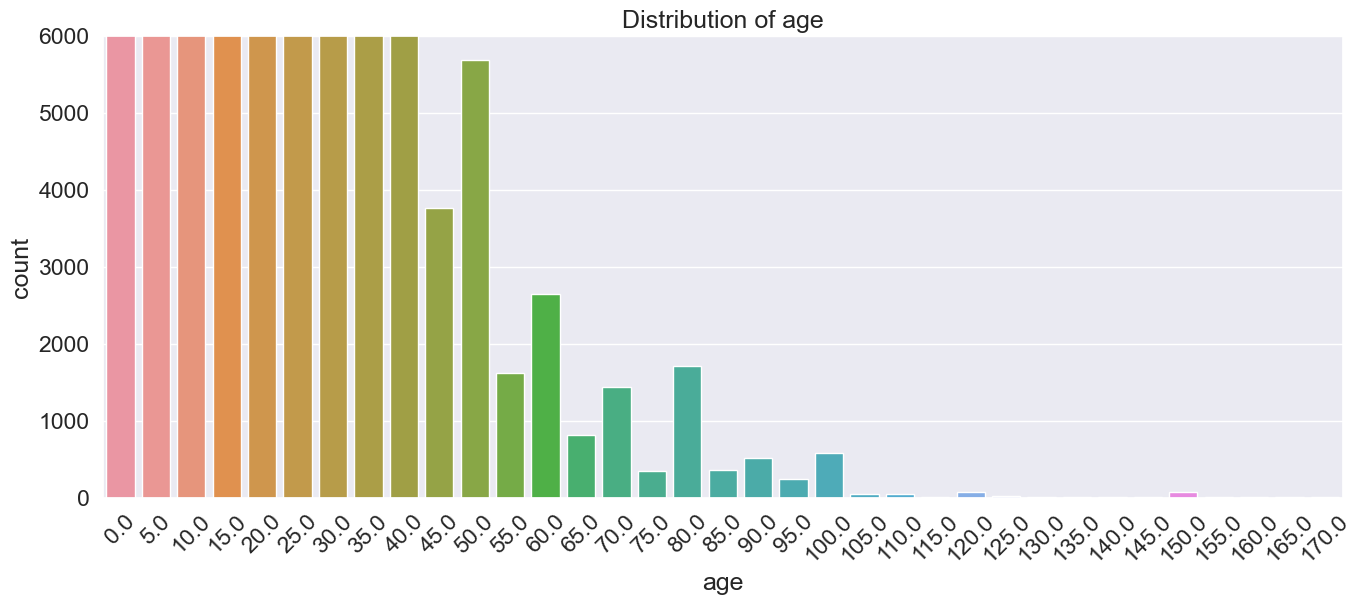

In [52]:
# Plotting the distribution
plt.figure(figsize=(16,6))
sns.set(font_scale=1.5)
sns.countplot(data=train_df, x='age')
plt.title("Distribution of age")
# set the x and y limits
plt.ylim(0, 6000)
plt.xticks(rotation=45)
plt.savefig('../reports/figures/age_distribution.svg',  bbox_inches = "tight")
plt.show()

#### Analysis for `height_percentage`

In [53]:
fromIQR_df = outlier_IQR_df[outlier_IQR_df['featureName'] == 'height_percentage']
fromZ_df = outlier_Z__df[outlier_Z__df['featureName'] == 'height_percentage']

print('IQR Value')
print(tabulate(fromIQR_df, headers='keys', tablefmt='psql'))
print('Z Value')
print(tabulate(fromZ_df, headers='keys', tablefmt='psql'))

IQR Value
+----+-------------------+-----------------+-------------------+-------------------+---------+----------+--------+
|    | featureName       |   outlierAmount |   minOutlierValue |   maxOutlierValue |    mean |   median |   mode |
|----+-------------------+-----------------+-------------------+-------------------+---------+----------+--------|
|  3 | height_percentage |            7843 |                10 |                32 | 5.43437 |        5 |      5 |
+----+-------------------+-----------------+-------------------+-------------------+---------+----------+--------+
Z Value
+----+-------------------+-----------------+-------------------+-------------------+---------+----------+--------+
|    | featureName       |   outlierAmount |   minOutlierValue |   maxOutlierValue |    mean |   median |   mode |
|----+-------------------+-----------------+-------------------+-------------------+---------+----------+--------|
|  3 | height_percentage |            7843 |                10

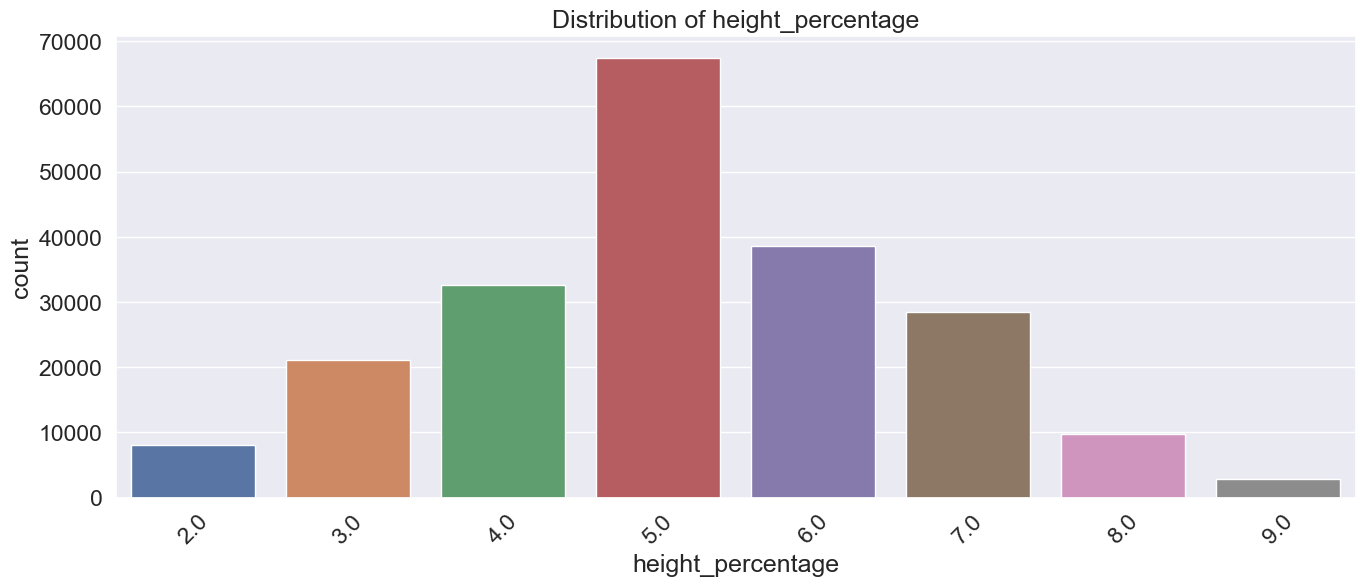

In [54]:
# Plotting the distribution
plt.figure(figsize=(16,6))
sns.countplot(data=train_df, x='height_percentage')
plt.title("Distribution of height_percentage")
plt.xticks(rotation=45)
plt.savefig('../reports/figures/height_percentage_distribution.svg', bbox_inches = "tight")
plt.show()

### Analysing the categorical features

In the exploration step we found out that the feature `has_superstructure_X` is not one-hot-encoded. Furthermore we can see that most buildings consist of mud_mortar_stone and timber. Less than 2% of the buildings have `has_superstructure_cement_mortar_stone`, `has_superstructure_rc_engineered` or `has_superstructure_other` set. In that regard these 3 values may be viewed as outliers.

In [55]:
has_superstructure_columns = [
    'has_superstructure_adobe_mud',
    'has_superstructure_mud_mortar_stone', 
    'has_superstructure_stone_flag',
    'has_superstructure_cement_mortar_stone',
    'has_superstructure_mud_mortar_brick',
    'has_superstructure_cement_mortar_brick', 
    'has_superstructure_timber',
    'has_superstructure_bamboo', 
    'has_superstructure_rc_non_engineered',
    'has_superstructure_rc_engineered', 
    'has_superstructure_other'
]

has_superstructure_df = train_df[has_superstructure_columns]
occurences = visualize.get_verbose_occurences(has_superstructure_df)

display(occurences)

plt.figure(figsize=(14,6))
sns.barplot(data=occurences, x='feature', y='occur. (abs)')
plt.xticks(rotation=30, ha='right')
plt.title('has_superstructure_X distribution')
plt.savefig('../reports/figures/has_superstructure_distribution.svg',  bbox_inches = "tight")
plt.show()

c:\Users\patri\Documents\GitLab\phase-1\src\visualization\visualize.py:43: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  sums = dataframe.sum().sort_values(ascending=False)


,feature,occur. (abs),occur. (rel)


ValueError: min() arg is an empty sequence

<Figure size 1400x600 with 0 Axes>

In [56]:
# removing the 3 features
features_to_drop = [
    'has_superstructure_cement_mortar_stone',
    'has_superstructure_rc_engineered', 
    'has_superstructure_other'
]

print(f'Amount of features {train_df.shape[1]}')
train_df = train_df.drop(features_to_drop, axis=1)
print(f'Amount of features after removal {train_df.shape[1]}')

Amount of features 38
Amount of features after removal 35


With regard to the `has_secondary_use_X` feature we found out in our exploration analysis that the rows that are not one-hot encoded always have the flag `has_secondary_use_other` set to 1, while the remaining features represent a valid one-hot encoding. 

In [57]:
has_secondary_use_columns = [
    'has_secondary_use',
    'has_secondary_use_agriculture', 
    'has_secondary_use_hotel',
    'has_secondary_use_rental', 
    'has_secondary_use_institution',
    'has_secondary_use_school', 
    'has_secondary_use_industry',
    'has_secondary_use_health_post', 
    'has_secondary_use_gov_office',
    'has_secondary_use_use_police', 
    'has_secondary_use_other'
]

has_secondary_use_df = pd.DataFrame(train_df[has_secondary_use_columns])

has_secondary_use_df['has_no_secondary_use'] = has_secondary_use_df['has_secondary_use'].replace({0:1, 1:0})
has_secondary_use_df = has_secondary_use_df.drop(columns=['has_secondary_use'])

In [58]:
has_secondary_use_df.columns = [
    'agriculture', 
    'hotel',
    'rental', 
    'institution',
    'school', 
    'industry',
    'health_post', 
    'gov_office',
    'police', 
    'other',
    'none'
]

encoded_has_secondary_use_df = build_features.create_one_hot_encoding(has_secondary_use_df)
decoded_has_secondary_use_df = build_features.revert_one_hot_encoding(encoded_has_secondary_use_df)

,value,count (abs),count (rel)
0,agriculture,202494,96.92%
1,hotel,4449,2.13%
2,rental,694,0.33%
3,other,566,0.27%
4,agriculture+other,424,0.20%
5,industry,130,0.06%
6,institution,82,0.04%
7,hotel+other,23,0.01%
8,health_post,21,0.01%
9,school,21,0.01%


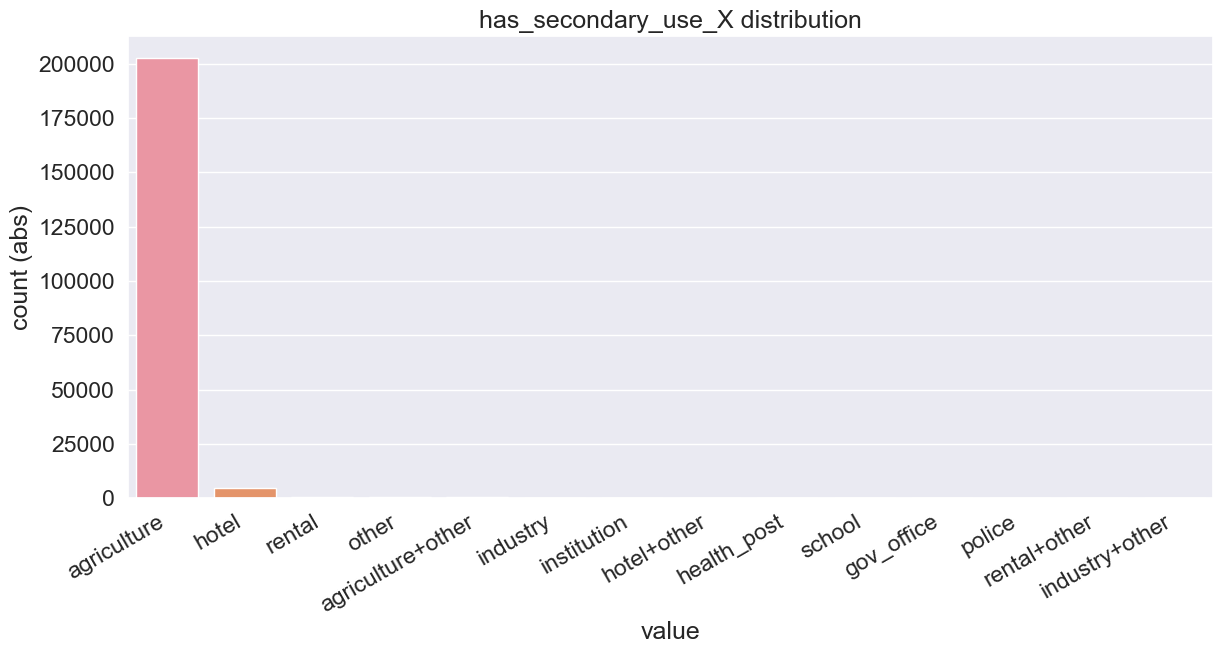

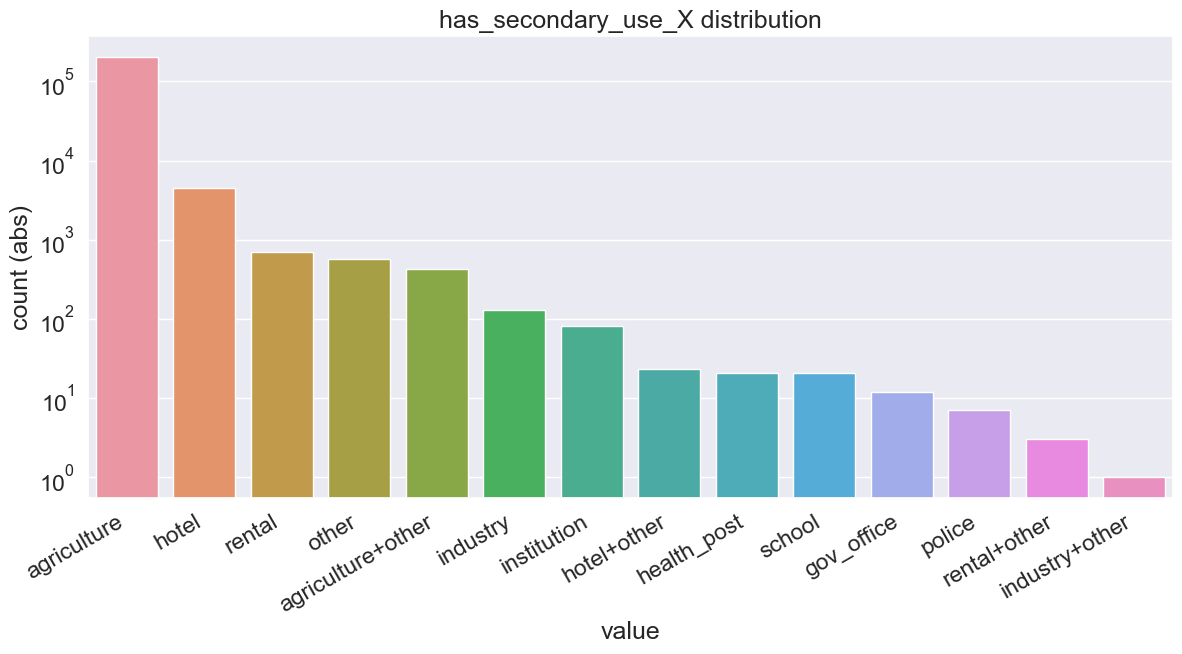

In [59]:
occurences = visualize.get_verbose_value_counts(decoded_has_secondary_use_df)

display(occurences)

plt.figure(figsize=(14,6))
sns.barplot(data=occurences, x='value', y='count (abs)')
plt.xticks(rotation=30, ha='right')
plt.title('has_secondary_use_X distribution')
plt.savefig('../reports/figures/has_secondary_use_distribution.svg',  bbox_inches = "tight")
plt.show()

plt.figure(figsize=(14,6))
sns.barplot(data=occurences, x='value', y='count (abs)')
plt.yscale('log')
plt.xticks(rotation=30, ha='right')
plt.title('has_secondary_use_X distribution')
plt.savefig('../reports/figures/has_secondary_use_distribution_log.svg',  bbox_inches = "tight")
plt.show()

With regard to the outlier detection of the other categorical features we are looking for features that are rare or occur with an unusually low frequency. To find outliers we conduct a frequency analysis. With this analysis a percentage threshold is set. All values that occur less times than the threshold are marked as outliers.

The analysis with a threshold of 2% shows that the following features have no outliers:
* 'land_surface_condition'
* 'roof_type' 
* 'other_floor_type'

On the other hand outliers have been found in the following features:
* geo_level_1_id
* geo_level_2_id
* geo_level_3_id
* foundation_type
* legal_ownership_status
* position
* ground_floor_type
* plan_configuration

In [60]:
# remove the has_secondary_use and has_superstructure columns
new_categorical_columns = list(set(categorical_columns) - set(has_superstructure_columns) - set(has_secondary_use_columns))
print(f'Columns: {new_categorical_columns}')

threshold = 0.02 # the threshold percentage after which values are marked as outliers
cat_outliers = build_features.find_outliers_by_threshold(train_df[new_categorical_columns], threshold, True)

Columns: ['geo_level_2_id', 'roof_type', 'foundation_type', 'ground_floor_type', 'plan_configuration', 'legal_ownership_status', 'other_floor_type', 'geo_level_1_id', 'geo_level_3_id', 'land_surface_condition', 'position']
Start: filtering out outliers with threshold 0.98
Features that have no outliers are: ['roof_type', 'other_floor_type', 'land_surface_condition']
Features with outliers:
Outliers for feature: geo_level_2_id
    A total of 369 outliers have been found
    0: 431
    1: 1260
    2: 674
    3: 888
    4: 602
    5: 921
    6: 970
    7: 1192
    8: 1086
    9: 1175
.. 359 more outliers were found
Outliers for feature: foundation_type
    A total of 1 outliers have been found
    0: h
Outliers for feature: ground_floor_type
    A total of 2 outliers have been found
    0: z
    1: m
Outliers for feature: plan_configuration
    A total of 8 outliers have been found
    0: u
    1: s
    2: a
    3: c
    4: o
    5: n
    6: f
    7: m
Outliers for feature: legal_ownershi

In [61]:
previousSize = len(train_df)
indizesToRemove = {}
print(f'Previous dataframe size {len(train_df)}')
for feature in train_df[new_categorical_columns]:
    
    # calculate the index that should be dropped
    indizesToRemove[feature] = [] # Initialize an empty list for each feature
    for value in cat_outliers[feature]:        
        indizesToRemove[feature].extend(build_features.find_value_indices(train_df[new_categorical_columns],feature, value))
    
    amountToDrop = len(indizesToRemove[feature])
    expectedAmount = len(train_df[feature]) - amountToDrop
    print(f'{amountToDrop} should be dropped')

    # assuming your data is in a pandas DataFrame named 'df'
    # remove the common outliers from the DataFrame
    train_df = train_df.drop(indizesToRemove[feature])
    train_df = train_df.reset_index(drop=True)
    print(f'Expected amount: {expectedAmount} and current amount: {len(train_df[feature])}')
newSize = len(train_df)
print(f'New dataframe size {len(train_df)}')
print(f'A total of {previousSize - newSize} rows have been dropped')

Previous dataframe size 208927
4157 should be dropped
Expected amount: 204770 and current amount: 204770
0 should be dropped
Expected amount: 204770 and current amount: 204770
1197 should be dropped
Expected amount: 203573 and current amount: 203573
1038 should be dropped
Expected amount: 202535 and current amount: 202535
3108 should be dropped
Expected amount: 199427 and current amount: 199427
2983 should be dropped
Expected amount: 196444 and current amount: 196444
0 should be dropped
Expected amount: 196444 and current amount: 196444
2389 should be dropped
Expected amount: 194055 and current amount: 194055
1500 should be dropped
Expected amount: 192555 and current amount: 192555
0 should be dropped
Expected amount: 192555 and current amount: 192555
513 should be dropped
Expected amount: 192042 and current amount: 192042
New dataframe size 192042
A total of 16885 rows have been dropped


Check all categorical features of train_df, if a value of a feature goes above the set threshold, the feature is considered imbalanced.

In [65]:
build_features.check_dataframe_for_imbalanced_features(train_df,0.95)

['plan_configuration',
 'has_superstructure_stone_flag',
 'has_superstructure_mud_mortar_brick',
 'has_superstructure_rc_non_engineered',
 'legal_ownership_status',
 'has_secondary_use_hotel',
 'has_secondary_use_rental',
 'has_secondary_use_institution',
 'has_secondary_use_school',
 'has_secondary_use_industry',
 'has_secondary_use_health_post',
 'has_secondary_use_gov_office',
 'has_secondary_use_use_police',
 'has_secondary_use_other']

In [34]:
def create_threshold_hist(df_series, threshold):
    print(f'Threshold: Rows of {df_series.name} ({df_series.count()}) x {threshold} = {int(df_series.count() * threshold)}')
    
    thresholdLine = threshold * df_series.count()
    df_series.hist()
    plt.axhline(y=thresholdLine, color='r', linestyle='-')
    plt.title(df_series.name)
    plt.ylabel('Count')
    plt.savefig(f'../reports/figures/histogramm_{df_series.name}.svg', format='svg')
    plt.show()

Threshold: Rows of plan_configuration (192042) x 0.95 = 182439


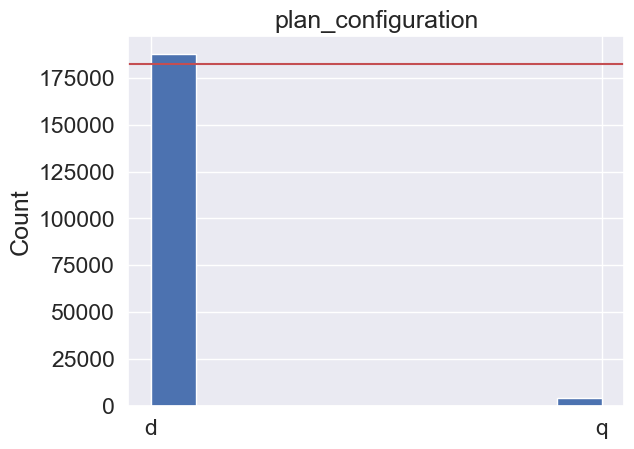

In [66]:
create_threshold_hist(train_df['plan_configuration'], 0.95)

Threshold: Rows of other_floor_type (192042) x 0.95 = 182439


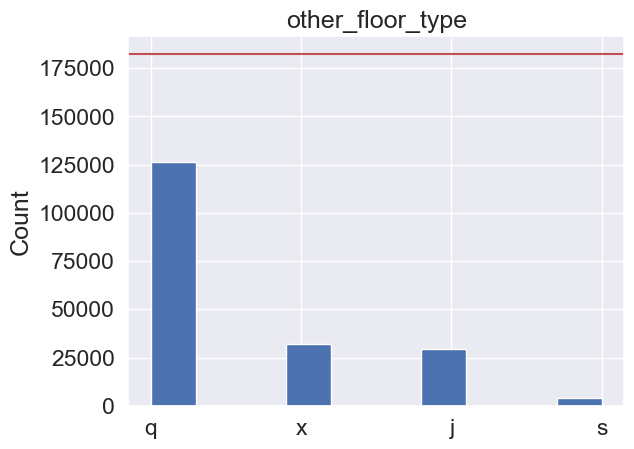

In [67]:
create_threshold_hist(train_df['other_floor_type'], 0.95)

Check numerical features for imbalance

<Axes: >

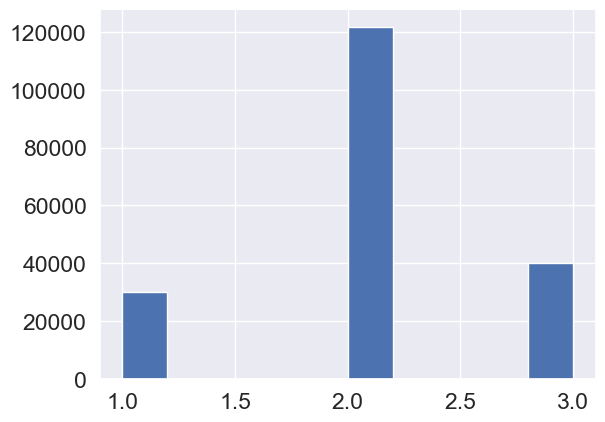

In [37]:
train_df['count_floors_pre_eq'].hist()

<Axes: >

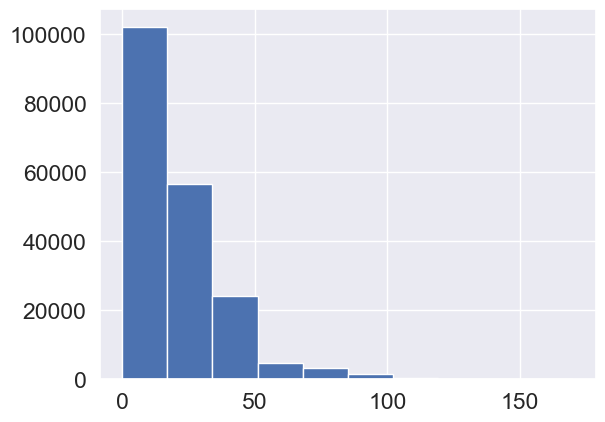

In [38]:
train_df['age'].hist()

<Axes: >

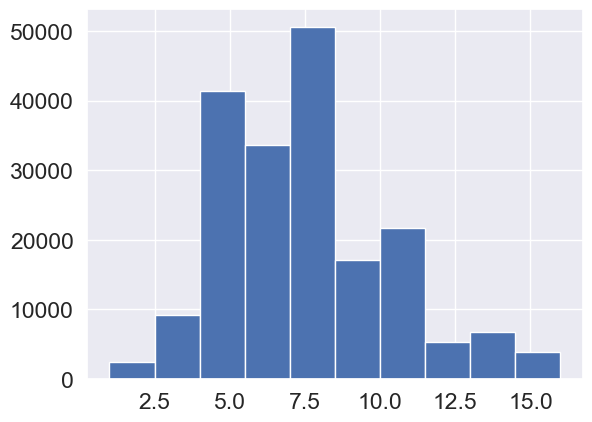

In [39]:
train_df['area_percentage'].hist()

<Axes: >

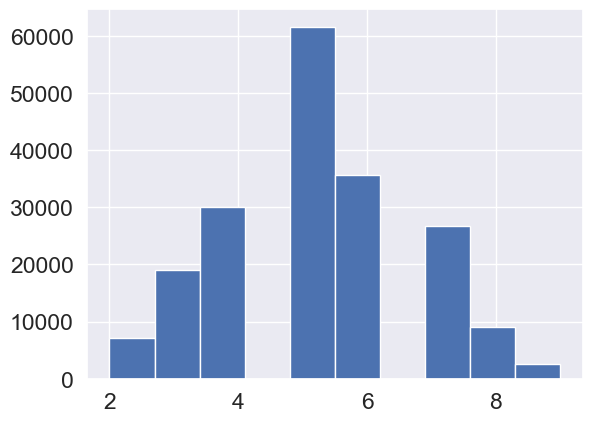

In [40]:
train_df['height_percentage'].hist()

<Axes: >

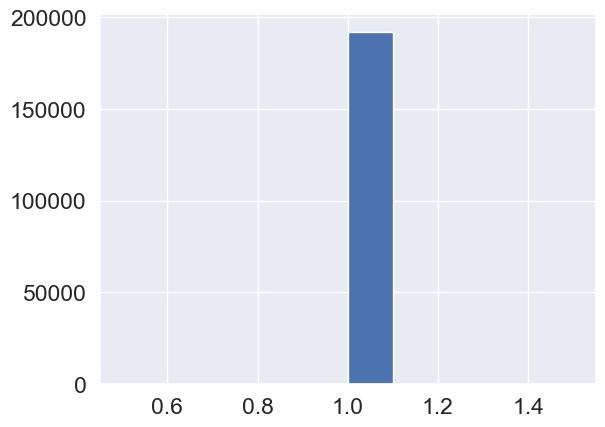

In [69]:
train_df['count_families'].hist()
